In [1]:
#hide
import sys
from IPython.display import HTML, display, Image, Video
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import (
    plotting as myplt,
    animation as myanim,
    coupling as bl,
    utils,
    matrix_lattice as ml,
    envelope_analysis as ea
)
from tools.utils import play, show
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = np.inf
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None
plot.rc['savefig.dpi'] = 'figure' 

# Coupled parametric oscillators
> Studying particle motion in the presence of time-dependent coupled linear forces.

- toc: true 
- badges: false
- comments: true
- categories: [physics, accelerators]

### Introduction 

A [previous post](https://austin-hoover.github.io/blog/physics/accelerators/2021/01/21/parametric_oscillators.html) examined the analytic solutions to the equation of motion describing a parametric oscillator, which is a harmonic oscillator whose physical properties are time-dependent (but not dependent on the state of the oscillator). This problem was motivated by describing the transverse oscillations of a particle in an accelerator. In this post, the treatment will be extended to a *coupled* parametric oscillator. Basically, we are trying to solve the following equation of motion:

$$x'' + k_{11}(s)x + k_{13}(s)y + k_{14}(s)y',$$
$$y'' + k_{33}(s)y + k_{31}(s)x + k_{32}(s)x',$$

where the prime denotes differentiation with respect to $s$. We also assume that each of the $k_{ij}$ coefficients are periodic, so $k_{ij}(s + L) = k_{ij}(s)$ for some $L$. 

#### Motivation 

The previous post discussed dipole and quadrupole magnetic fields, which have the special property that their fields depend linearly on $x$ and $y$, and are also uncoupled. Of course there are many other configurations possible. First, consider a solenoid magnet:

<br>
<img src="images_2021-01-25/solenoid.jpg" width=300>
<figcaption>Credit: brilliant.org</figcaption>

The field within the coils points in the longitudinal direction and is approximatly constant ($\mathbf{B}_{sol} = B_0\hat{s}$). Plugging this into the Lorentz force equation we find: 

$$\dot{\mathbf{v}} = \frac{q}{m} \mathbf{v} \times \mathbf{B} = \frac{qB_0}{m}\left({v_y\hat{x} - v_x\hat{y}}\right).$$

This means the motion in $x$ depends on the velocity in $y$, and vice versa, so this will contribute to $k_{14}$ and $k_{32}$. Coupling can also be produced from transverse magnetic fields. We again write the multipole expansion of this field:

$$B_y + iB_x = B_{ref}\sum_{n=1}^{\infty}\left({B_n + iA_n}\right)\left(\frac{x + iy}{R_{ref}}\right)^{n-1}.$$

<br>
<img src="images_2021-01-25/multipoles.png">
<figcaption>Credit: Jeff Holmes</figcaption>
<br>

There will be nonlinear coupling (terms proportional to $x^j y^k$, where $j,k > 1$ when $n > 2$, but we are interested in *linear* coupling. This occurs when the skew quadrupole term $A_2$ is nonzero, which is true anytime a quadrupole is tilted in the transverse plane. The field couples the motion in one plane to the displacement in the other, contributing to the $k_{13}$ and $k_{31}$ terms.

#### Approach

Let's review the approach we took in analyzing the 1D parametric oscillator. We wrote the solution in pseudo-harmonic form, with an amplitude and phase which depended on time. We then found that particles travel along the boundary of an ellipse in 2D phase space, the area of which is a constant of the motion (we will denote this area by $\epsilon_x$). To understand the motion, we just need to know the dimensions and orientation of this ellipse, for which we proposed the parameters $\alpha_x$ and $\beta_x$, as well as the location of the particle on the ellipse boundary, which is determined by the phase $\mu_x$. All the subscripts can be replaced by $y$ to handle the vertical motion. We also wrote a transfer matrix $\mathbf{M}$, which connects the initial and final phase space coordinates after tracking through one period, from the parameters in the following form:

$$\mathbf{M} = \mathbf{V}\mathbf{P}\mathbf{V}^{-1},$$

where $\mathbf{V}^{-1}$ is a function of $\alpha_x$ and $\beta_x$ and transforms the ellipse into a circle while preserving the area, and $\mathbf{P}$ is a rotation in phase space according to the phase advance $\mu_x$. Basically, $\mathbf{V}$ turns the parametric oscillator into a harmonic oscillator.

This is a very elegant way to describe the motion with a minimal set of parameters. The question is: can we do something similar for coupled motion, in which the phase space is 4D, not 2D? To start, let's track a particle in a lattice with a nonzero skew quadrupole coefficient, plotting its phase space coordinates at one position after every period.

In [17]:
#hide
L = 5.0
k1, k2 = 0.25, 0.25
lattice = ml.fodo(k1, k2, L, fill_fac=0.5, quad_tilt=1, start='drift')

nturns = 1000
eps1 = 40 # [mm-mrad]
eps2 = 10 # [mm-mrad]
psi1 = 0 # initial phase of eigenvector 1
psi2 = np.radians(90) # initial phase of eigenvector 2

# Form coordinate vector
x1 = np.real(np.sqrt(eps1) * lattice.v1 * np.exp(1j*psi1)) # mode 1 contribution
x2 = np.real(np.sqrt(eps2) * lattice.v2 * np.exp(1j*psi2)) # mode 2 contribution
x = x1 + x2

# Track
X1 = lattice.track_part(x1, nturns)
X2 = lattice.track_part(x2, nturns)
X = lattice.track_part(x, nturns)

In [3]:
#hide_input
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.grid'] = False
anim = myanim.corner_onepart(
    X[:75], 
    dims='all', 
    figsize=6, 
    show_history=True, 
    text_fmt='Period = {}',
    fps=5,
    history_kws=dict(s=6, alpha=0.5, color='pink7'),
    color='black',
    s=8
)
anim

The particle traces interesting donut-like shapes in horizontal ($x$-$x'$) and vertical ($y$-$y'$) phase space instead of ellipses. Below shows the shapes after 1000 periods.

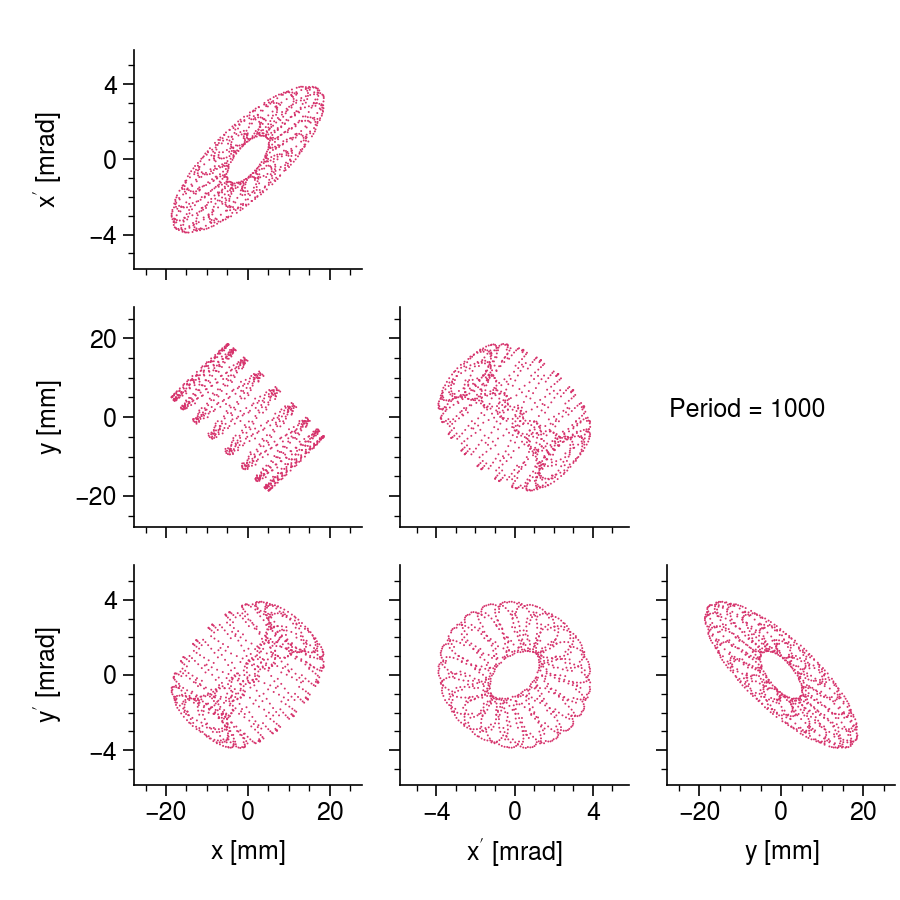

In [4]:
#hide_input
myplt.corner(X, diag_kind=None, figsize=4.5, alpha=1, s=2, c='pink7',
             text='Period = 1000');

There is definitely more than one frequency present, which we see if we plot the $x$ and $y$ position vs period number and take the FFT. 

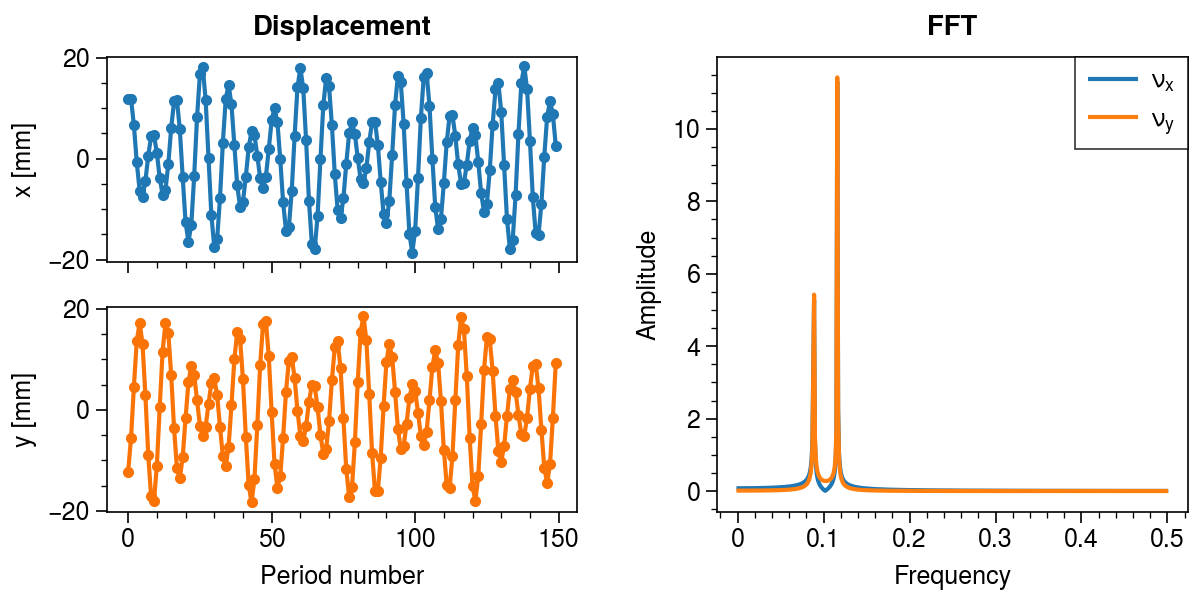

In [5]:
#hide_input

# TBT trajectory
fig, axes = plot.subplots([[1, 3], [2, 3]], figsize=(6, 3), span=False, wspace=[0.7])
x, y = X[:150, [0, 2]].T
axes[0].plot(x, marker='.')
axes[1].plot(y, marker='.', color='orange')
axes[0].format(ylabel='x [mm]')
axes[1].format(ylabel='y [mm]', xlabel='Period number')

# FFT
x, y = X[:, [0, 2]].T
N = len(x)
M = N // 2
f = (1/N) * np.arange(M)
xf = (1/M) * abs(scipy.fft.fft(x)[:M])
yf = (1/M) * abs(scipy.fft.fft(y)[:M])
axes.format(toplabels=['Displacement', 'FFT'])
axes[2].format(xlabel='Frequency', ylabel='Amplitude')
axes[2].plot(f[1:], xf[1:], label=r'$\nu_x$')
axes[2].plot(f[1:], yf[1:], label=r'$\nu_y$')
axes[2].legend(ncols=1);

This is typical of a coupled oscillator. Such systems are typically understood as the superposition of [normal modes](https://en.wikipedia.org/wiki/Normal_mode), each of which corresponds to a single frequency. For example, consider two masses connected with a spring. There are two possible ways for the masses to oscillate at the same frequency. The first is a *breathing mode* in which they move in opposite directions, and the second is a *sloshing mode* in which they move in the same direction. The motion is simply the sum of these two modes. We will try to do something similar for a coupled parameteric oscillator.

### Solution

#### Transfer matrix eigenvectors

If the phase space coordinate vector $\mathbf{x} = (x, x', y, y')^T$ evolves according to

$$\mathbf{x} \rightarrow \mathbf{Mx},$$

where $\rightarrow$ represents tracking through one period, it can be shown that $\mathbf{M}$ is [symplectic](https://en.wikipedia.org/wiki/Symplectic_matrix#Properties) due to the Hamiltonian mechanics of the system. A consequence of the symplecticity condition is that $\mathbf{M}$ is fully described by 10 numbers instead of 16. Our method examines the eigenvectors of $\mathbf{M}$: 

$$\mathbf{Mv} = e^{-i\mu}\mathbf{v}.$$

The symplecticity condition also causes the eigenvalues and eigenvectors come in two complex conjugate pairs; this gives $\mathbf{v}_1$, $\mathbf{v}_2$, $\mu_1$, $\mu_2$ and their complex conjugates. The seemingly complex motion seen in the last animation is greatly simplified when written in terms of the eigenvectors. We can write any cooridinate vector as a linear combination of the real and imaginary components of $\mathbf{v}_1$ and $\mathbf{v}_2$:

$$\mathbf{x} = Re \left(\sqrt{\epsilon_1}\mathbf{v}_1e^{-i\psi_1} + \sqrt{\epsilon_2}\mathbf{v}_2e^{-i\psi_2}\right).$$

We've introduced two initial amplitudes ($\epsilon_1$ and $\epsilon_2$) as well as two initial phases ($\psi_1$ and $\psi_2$). Applying the transfer matrix then simply tacks on a phase. Thus, what we are observing are the 2D projections of the real components of these eigenvectors as they rotate in the complex plane.

$$\mathbf{Mx} = Re \left(\sqrt{\epsilon_1}\mathbf{v}_1e^{-i\left(\psi_1 + \mu_1\right)} + \sqrt{\epsilon_2}\mathbf{v}_2e^{-i(\psi_2 + \mu_2)}\right).$$

Let's replay the animation, but this time draw a red arrow for $\mathbf{v}_1$ and a blue arrow for $\mathbf{v}_2$. We've chosen $\epsilon_1 = 4 \epsilon_2$ and $\psi_2 - \psi_1 = \pi/2$.

In [6]:
#hide_input
anim = myanim.corner_onepart(
    X[:40], 
    vecs=[X1, X2],
    dims='all', 
    figsize=6, 
    show_history=False, 
    text_fmt='Period = {}',
    fps=5,
    color='black',
    s=8
)
anim

That really simplifies things! Each eigenvector simply rotates at its frequency $\mu_l$. It also explains why the amplitude in the $x$-$x'$ and $y$-$y'$ planes trade back and forth: it is because the projections of the eigenvectors rotate at different frequencies, sometimes aligning and sometimes anti-aligning. Because of this, the previous invariants $\epsilon_x$ and $\epsilon_y$ are replaced by $\epsilon_1$ and $\epsilon_2$ as the invariants. It is helpful to think of a torus (shown below). The two amplitudes would determine the inner and outer radii of the torus, and the two phases determine the location of a particle on the surface.

<img src="images_2021-01-25/torus.png" width=300>
<figcaption>Credit: Wikipedia</figcaption>

#### Parameterization of eigenvectors

We are now going to introduce a set of parameters for these eigenvectors, and in turn the transfer matrix. We already have two phases, so that leaves 8 parameters. Our strategy is to observe that each eigenvector traces an ellipse in both horizontal ($x$-$x'$) and vertical ($y$-$y'$) phase space. Then, we will simply assign an $\alpha$ function and $\beta$ function to each of these ellipses. So, for the ellipse traced by $\mathbf{v}_1$ in the $x$-$x'$ plane, we have $\beta_{1x}$ and $\alpha_{1x}$, and then for the second eigenvector we have $\beta_{2x}$ and $\alpha_{2x}$. The same thing goes for the vertical dimension with $x$ replaced by $y$.

<img src="images_2021-01-25/4dtwiss.png">
<br>

The actual eigenvectors written in terms of the parameters are

$$\vec{v}_1 = \begin{bmatrix}\sqrt{\beta_{1x}} \\\\-\frac{\alpha_{1x} + i(1-u)}{\sqrt{\beta_{1x}}} \\\\ \sqrt{\beta_{1y}}e^{i\nu_1} \\\\ -\frac{\alpha_{1y} + iu}{\sqrt{\beta_{1y}}} e^{i\nu_1} \end{bmatrix}, \quad \vec{v}_2 = \begin{bmatrix} \sqrt{\beta_{2x}}e^{i\nu_2} \\\\ -\frac{\alpha_{2x} + iu}{\sqrt{\beta_{2x}}}e^{i\nu_2} \\\\ \sqrt{\beta_{2y}} \\\\ -\frac{\alpha_{2y} + i(1-u)}{\sqrt{\beta_{2y}}} \end{bmatrix}$$

So in addition to the phases $\mu_1$ and $\mu_2$ we have $\alpha_{1x}$, $\alpha_{2x}$, $\alpha_{1y}$, $\alpha_{2y}$, $\beta_{1x}$, $\beta_{2x}$, $\beta_{1y}$, and $\beta_{2y}$. That's pretty much it. There are a few other parameters we need to introduce to simplify the notation, but they are not independent. The first is $u$, which, as noted in the figure, determines the areas of the ellipses in one plane relative to the other. The second and third are $\nu_1$ and $\nu_2$, which are phase differences between the $x$ and $y$ components of the eigenvectors (in the animation they are either $0$ or $\pi$). I won't discuss these here. The last thing to note is that the parameters reduce to their 1D definitions when there is no coupling in the lattice. So we would have $\beta_{1x}, \beta_{2y} \rightarrow \beta_{x}, \beta_{y}$ and $\beta_{2x}, \beta_{1y} \rightarrow 0$, and similar for $\alpha$. The invariants and phase advances would also revert back to their original values: $\epsilon_{1,2} \rightarrow \epsilon_{x,y}$ and $\mu_{1,2} \rightarrow \mu_{x,y}$.

#### Floquet transformation 

These eigenvectors can also be used to construct a transformation which removes both the variance in the focusing strength and the coupling between the planes, turning the coupled parametric oscillator into an uncoupled harmonic oscillator. In other words, we seek a matrix $\mathbf{V}$ such that 

$$\mathbf{V^{-1} M V} = \mathbf{P} = 
\begin{bmatrix}
    \cos{\mu_1} & \sin{\mu_1}  & 0 & 0 \\
    -\sin{\mu_1} & \cos{\mu_1}  & 0 & 0 \\
    0 & 0 & \cos{\mu_2} & \sin{\mu_2} \\
    0 & 0 & -\sin{\mu_2} & \cos{\mu_2}
\end{bmatrix}
$$

We can do this simply by rewriting the following equation (I haven't yet figured out how to number equations in Jupyter):

$$\mathbf{x} = Re \left(\sqrt{\epsilon_1}\mathbf{v}_1e^{-i\psi_1} + \sqrt{\epsilon_2}\mathbf{v}_2e^{-i\psi_2}\right)$$

in matrix form as $\mathbf{x} = \mathbf{V}\mathbf{x}_n$ with 

$$\mathbf{x}_n = \begin{bmatrix}
  \sqrt{\epsilon_1}\cos{\psi_1} \\
  -\sqrt{\epsilon_1}\sin{\psi_1} \\  
  \sqrt{\epsilon_2}\cos{\psi_2} \\ 
  -\sqrt{\epsilon_2}\sin{\psi_2}
\end{bmatrix}
$$

$$\mathbf{V} = \left[{Re(\mathbf{v}_1), -Im(\mathbf{v}_1), Re(\mathbf{v}_2), -Im(\mathbf{v}_2)}\right]$$

Let's observe the motion in these new coordinates $\mathbf{x}_n$.

In [19]:
#hide_input
x = x1 + x2
X1 = lattice.track_part(x1, nturns, norm_coords=True)
X2 = lattice.track_part(x2, nturns, norm_coords=True)
X1[:, 2:] = 0
X2[:, :2] = 0
X = lattice.track_part(x, nturns, norm_coords=True)

anim = myanim.corner_onepart(
    X[:40], 
    vecs=[X1, X2],
    dims='all', 
    figsize=6, 
    show_history=False, 
    text_fmt='Period = {}',
    fps=5,
    norm_labels=True,
    color='black',
    s=8
)
anim

The motion is uncoupled after this transformation; i.e., particles move in a circle of area $\varepsilon_1$ in the $x_n$-$x_n'$ plane at frequency $\mu_1$, and in a circle of area $\varepsilon_2$ in the $y_n$-$y_n'$ plane at frequency $\mu_2$.

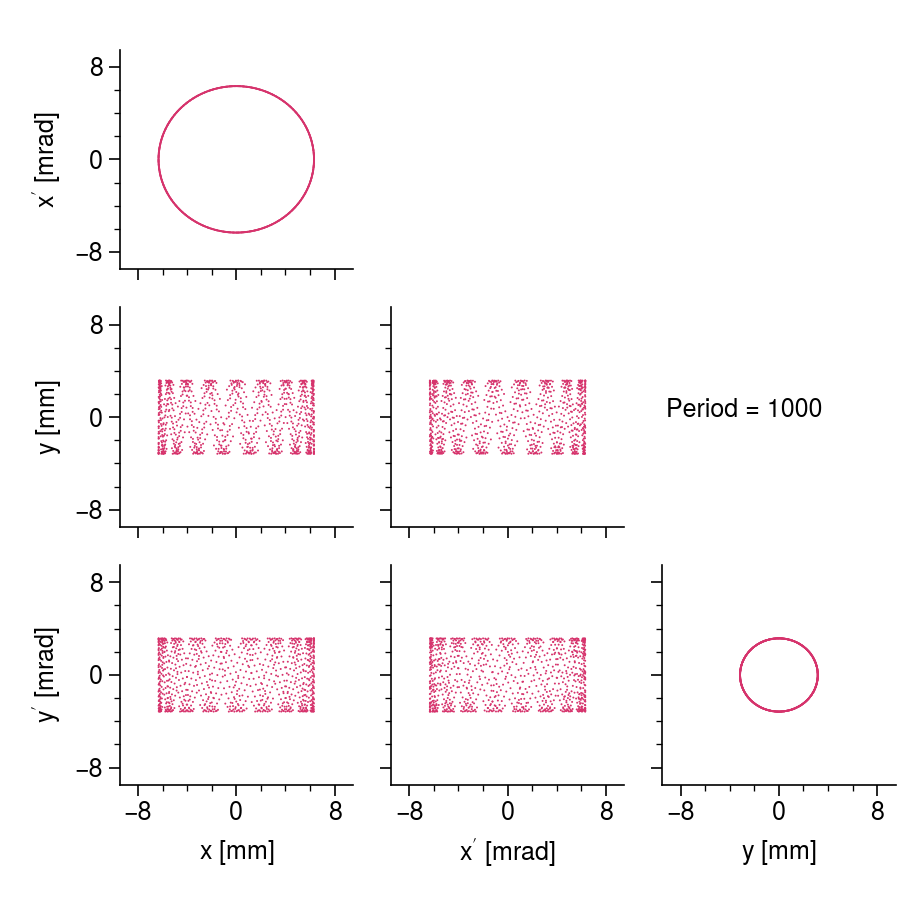

In [16]:
#hide_input
myplt.corner(X, diag_kind=None, figsize=4.5, alpha=1, s=2, c='pink7',
             text='Period = 1000');

### Conclusion 

The method introduced here allows us to describe the evolution of a parametric oscillator using the minimum number of parameters. Our physical motivation was an accelerator lattice with linear, coupled forces, such as when skew quadrupole terms are present in the magnetic fields. There is no agreed upon method to do this among accelerator physicists, but I like (and know) this method the best, and have used it in my research. I've left out many details which can be found in the paper by [Lebedev and Bogacz](https://arxiv.org/abs/1207.5526). The paper by [Ripken](https://aip.scitation.org/doi/abs/10.1063/1.38050) is also very helpful.